# Algorithmic Trading

<img align="left" width="80" height="200" src="https://img.shields.io/badge/python-v3.6-blue.svg">
<br>

## Notebook by [Marco Tavora](https://marcotavora.me/)

### Table of contents

1. [Summary](#Summary)
1. [Definitions](#Definitions)
3. [Modules](#Modules)
4. [Time Series](#Time-Series)
5. [Strategy](#Strategy)
6. [Moving Windows](#Moving-Windows)

### Summary 
[[go back to the top]](#Table-of-contents)

I will briefly describe:
- How to build a [trend trading](https://en.wikipedia.org/wiki/Trend_following) strategy
- How to backtest it 
- How we can optimize it 

### Definitions 
[[go back to the top]](#Table-of-contents)


Trend trading can be [defined as](https://en.wikipedia.org/wiki/Trend_following):

> ... a trading strategy according to which one should buy an asset when its price trend goes up, and sell when its trend goes down, expecting price movements to continue.

Again borrowing from [Wikipedia](#https://en.wikipedia.org/wiki/Backtesting), backtesting:
> ... seeks to estimate the performance of a strategy or model if it had been employed during a past period. This requires simulating past conditions with sufficient detail, making one limitation of backtesting the need for detailed historical data. 

### Modules 
[[go back to the top]](#Table-of-contents)

In [39]:
%run modules_algo_trading_v4.ipynb

### Data from `yahoo` or `Quandl`
[[go back to the top]](#Table-of-contents)

In [2]:
start, end = datetime.datetime(2000, 1, 1), datetime.datetime(2018, 1, 1)
apple = pdr.get_data_yahoo('AAPL', start=start, end=end)
apple.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-03,3.745536,4.017857,3.631696,3.997768,3.543045,133949200
2000-01-04,3.866071,3.950893,3.613839,3.660714,3.244329,128094400
2000-01-05,3.705357,3.948661,3.678571,3.714286,3.291807,194580400
2000-01-06,3.790179,3.821429,3.392857,3.392857,3.006939,191993200
2000-01-07,3.446429,3.607143,3.410714,3.553571,3.149374,115183600


#### Checking for null values

In [3]:
apple.isnull().any().unique()

array([False])

In [4]:
start, end ="2000-01-01", "2018-01-01"
apple = quandl.get("WIKI/AAPL", start_date=start, end_date=end)
apple.columns = [el.lower().replace('.', '').replace(' ', '_') for el in apple.columns]
apple.head()

,open,high,low,close,volume,ex-dividend,split_ratio,adj_open,adj_high,adj_low,adj_close,adj_volume
Date,,,,,,,,,,,,
2000-01-03,104.87,112.50,101.69,111.94,4783900.0,0.0,1.0,3.369314,3.614454,3.267146,3.596463,133949200.0
2000-01-04,108.25,110.62,101.19,102.50,4574800.0,0.0,1.0,3.477908,3.554053,3.251081,3.293170,128094400.0
2000-01-05,103.75,110.56,103.00,104.00,6949300.0,0.0,1.0,3.333330,3.552125,3.309234,3.341362,194580400.0
2000-01-06,106.12,107.00,95.00,95.00,6856900.0,0.0,1.0,3.409475,3.437748,3.052206,3.052206,191993200.0
2000-01-07,96.50,101.00,95.50,99.50,4113700.0,0.0,1.0,3.100399,3.244977,3.068270,3.196784,115183600.0


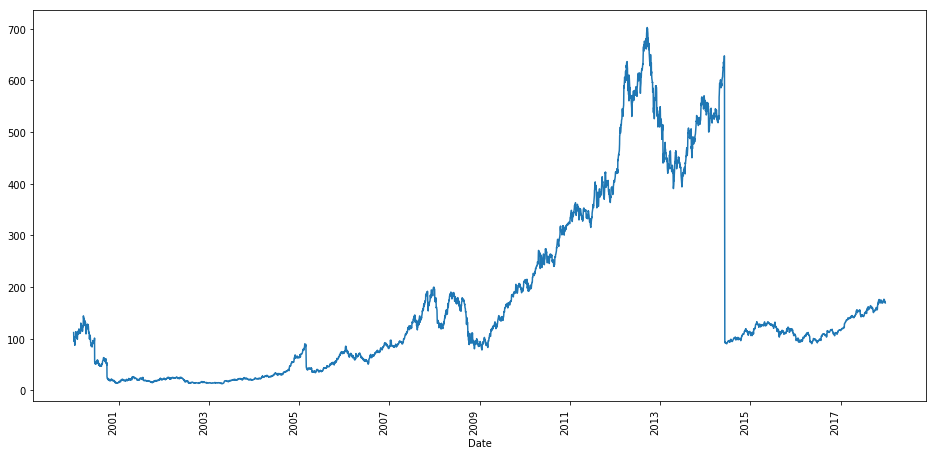

In [5]:
plt.rcParams['figure.figsize'] = 16, 8
apple['close'].plot(grid=False, rot=90);
plt.show();

### Strategy
[[go back to the top]](#Table-of-contents)

From [here](https://github.com/ranaroussi/fix-yahoo-finance) we get:

In [6]:
import fix_yahoo_finance as yf
yf.pdr_override() 

The strategy consists in:
- Setting the sizes of the short moving window `smw` and long moving window `lmw`
- Create an empty `DataFrame` for signals, called `sig`
- Fill the columns of `sig` with the SMA and LMA
- Fill the `sug` column (starting from row `smw`), inserting ones when the value of column `short_ma` is larger than `long_ma`
- Create a column of positions

In [8]:
smw, lmw = 40, 100
sig = pd.DataFrame(index=apple.index, columns = ['short_ma','long_ma' ])
sig['signal'], sig['short_ma'], sig['long_ma'] = 0.0, 0.0, 0.0
sig['short_ma'] = apple['close'].rolling(window=smw,
                                             min_periods=1, 
                                             center=False).mean()

sig['long_ma'] = apple['close'].rolling(window=lmw, 
                                            min_periods=1, 
                                            center=False).mean()
sig['signal'][smw:] = np.where(sig['short_ma'][smw:] 
                                            > sig['long_ma'][smw:], 1.0, 0.0)   

sig['pos'] = sig['signal'].diff()

sig

,short_ma,long_ma,signal,pos
Date,,,,
2000-01-03,111.940000,111.940000,0.0,NaN
2000-01-04,107.220000,107.220000,0.0,0.0
2000-01-05,106.146667,106.146667,0.0,0.0
2000-01-06,103.360000,103.360000,0.0,0.0
2000-01-07,102.588000,102.588000,0.0,0.0
2000-01-10,101.781667,101.781667,0.0,0.0
2000-01-11,100.491429,100.491429,0.0,0.0
2000-01-12,98.828750,98.828750,0.0,0.0
2000-01-13,98.597778,98.597778,0.0,0.0


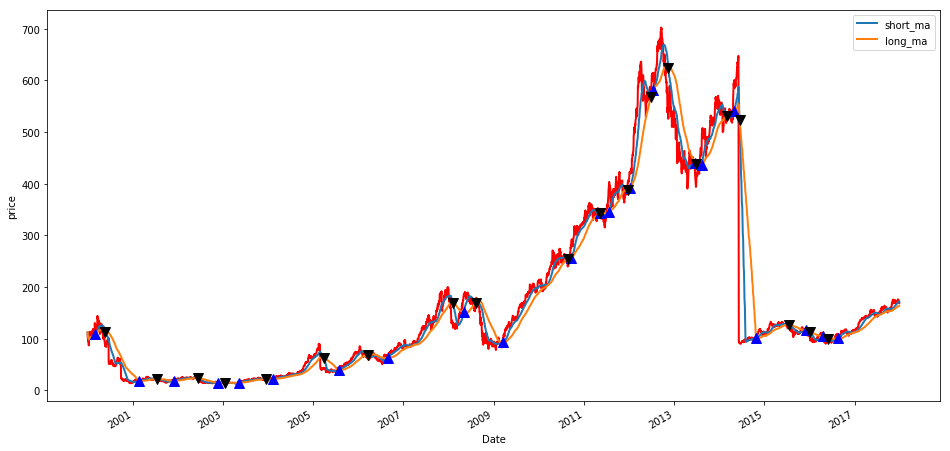

In [23]:
ylabel, col, cols_ma ='price', 'close', ['short_ma', 'long_ma']
afa.plot_function(apple, sig, ylabel, col, cols_ma)

### Backtesting Steps
[[go back to the top]](#Table-of-contents)

Steps:
- Set the initial capital
- Buy a $N$ shares
- Initialize the portfolio with value owned initially and store the difference in shares owned 
- Add `holdings`, `cash`, `total` and `r` to portfolio
- Plot equity curve 
- Plot the "buy" and "sellE trades versus the equity curve

In [24]:
initial_capital, N = 2000000.0, 200
pos = pd.DataFrame(index=sig.index).fillna(0.0)
pos['AAPL'] = 100*sig['signal']   
ptf = pos.multiply(apple['adj_close'], axis=0)
pos_diff = pos.diff()
ptf['hds'] = (pos.multiply(apple['adj_close'], axis=0)).sum(axis=1)
ptf['cash'] = initial_capital - (pos_diff.multiply(apple['adj_close'], axis=0)).sum(axis=1).cumsum()   
ptf['tot'] = ptf['cash'] + ptf['hds']
ptf['r'] = ptf['tot'].pct_change()

ptf.head()

,AAPL,hds,cash,tot,r
Date,,,,,
2000-01-03,0.0,0.0,2000000.0,2000000.0,NaN
2000-01-04,0.0,0.0,2000000.0,2000000.0,0.0
2000-01-05,0.0,0.0,2000000.0,2000000.0,0.0
2000-01-06,0.0,0.0,2000000.0,2000000.0,0.0
2000-01-07,0.0,0.0,2000000.0,2000000.0,0.0


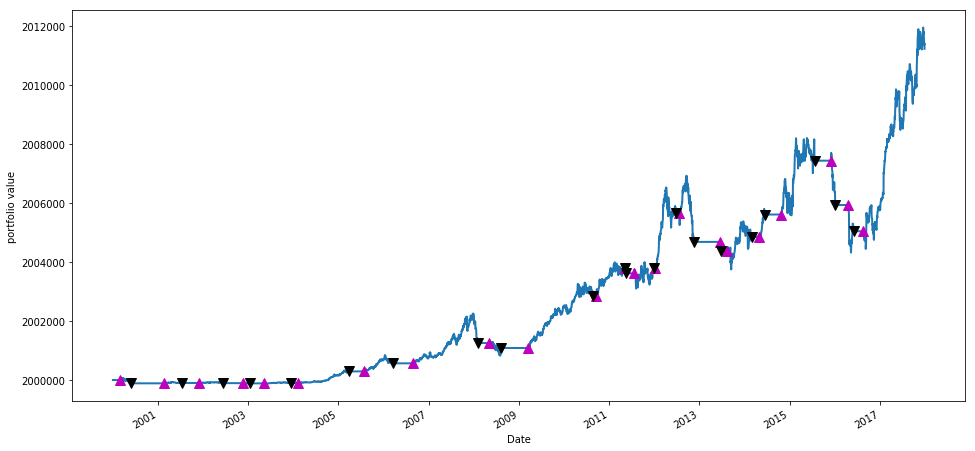

In [40]:
df, ylabel, col = ptf, 'portfolio value', 'tot'
afa.plot_function_2(df, sig, ylabel, col)

### Sharpe Ratio and Maximum Drawdown
[[go back to the top]](#Table-of-contents)

In [42]:
returns = ptf['r']
sharpe_ratio = np.sqrt(252)*(returns.mean() / returns.std())
print('sharpe_ratio is:',round(sharpe_ratio, 3))

sharpe_ratio is: 0.543


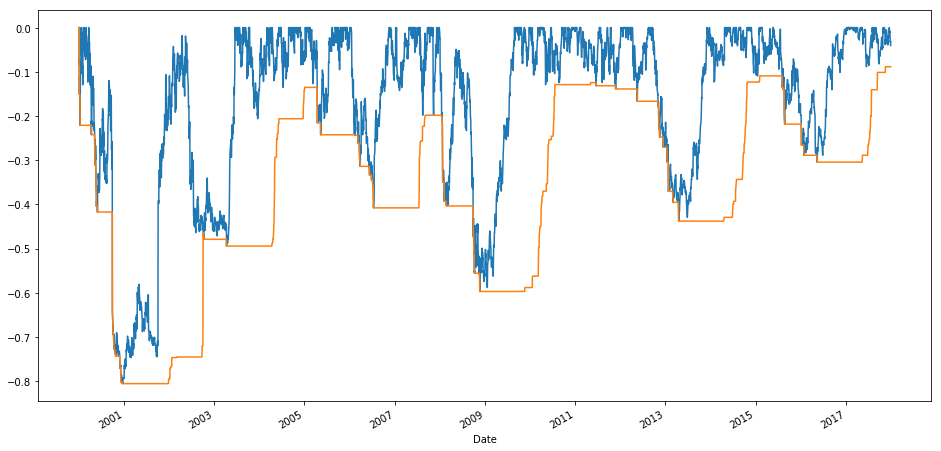

In [44]:
window = 252
rolling_max = apple['adj_close'].rolling(window, min_periods=1).max()
daily_drawdown = (apple['adj_close']/rolling_max - 1.0)
max_daily_drawdown = daily_drawdown.rolling(window, min_periods=1).min()
daily_drawdown.plot()
max_daily_drawdown.plot()
plt.show();